In [1]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from matplotlib.ticker import FuncFormatter

In [5]:
pd.set_option('display.max_rows',100)

In [6]:
predict_date='2018_12_23'

## Consumption_afterPV mode peakload already reduced from discharge but mode dutycycle not reduced

In [7]:
def predictcon(predict_date):
    num_day=30

    predict_day=int(predict_date[8:])
    predict_month=int(predict_date[5:7])
    predict_year=int(predict_date[0:4])

    str(predict_year)+'_'+str(predict_month)+'_'+str(predict_day)

    daybefore=[]
    pmb=predict_month-1
    dayleft=num_day-predict_day

    if predict_day>num_day:
        day=predict_day-num_day
        while day<predict_day:
            daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(day).zfill(2))
            day+=1
    else:
        if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
            for i in range(31-dayleft,32,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
        elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
            for i in range(30-dayleft,31,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
        else:
            if predict_year%4==0:
                for i in range(29-dayleft,30,1):
                    daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
                for i in range(1,predict_day,1):
                    daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
            else:
                for i in range(28-dayleft,29,1):
                    daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
                for i in range(1,predict_day,1):
                    daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))

    pathlist=[]
    for i in daybefore:
        pathlist.append('Energy_Balance_'+str(i))

    def clean(path):
        rawdata=pd.read_csv(path+".csv", delimiter=";" )
        deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
        rawdata.drop(deleteindex,inplace=True)
        rawdata.rename(columns={' ':'Time'},inplace=True)
        rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
        rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
        rawdata['Time']=pd.to_datetime(rawdata.Time)
        rawdata.set_index('Time', inplace=True)
        for i in rawdata.columns:
            if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
                rawdata.drop([i],axis=1,inplace=True)
        for i in rawdata.columns:
            rawdata[i].fillna('0',inplace=True)
            rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
            rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
        rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
        rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
        rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
        rawdata.drop(['Generation'],axis=1,inplace=True)
        return rawdata

    rawdata=[]

    for i in pathlist:
        df=clean(i)
        rawdata.append(df)


    data=rawdata[0]
    for i in range(num_day-1):
        data=pd.concat([data,rawdata[i+1]])


    for i in range(data.shape[0]):
        if data.iloc[i,0]==0:
            data.iloc[i,0]=data.iloc[i-96,0]

    fit4 = ExponentialSmoothing(data.Consumption, seasonal_periods=96, trend='add' ,seasonal='mul').fit()

    fit4.fittedvalues.plot(style='--', color='red')

    forecast=fit4.forecast(96)

    params=fit4.model.params
    Consumption=[]
    for i in forecast:
        Consumption.append(i)
    return Consumption


In [8]:
def predictgen(predict_date):
    import os
    import pandas as pd
    import json
    import datetime

    def createDayDataframe(filename):
        path = "tongsdata/"
        filedate = filename.split(".")[0].split("-")

        with open(path + filename, 'r', encoding='utf-8') as fin:
            data_json = json.loads(fin.read())

        #  Create X DataFrame
        todayData = {time: data_json[time]['currently'] for time in data_json}
        todayData_DF = pd.DataFrame(todayData).T

        #  Create y DataFrame
        energyBalanceFilename = "energyBalance/Energy_Balance_{}_{}_{}.csv".format(filedate[0], filedate[1], filedate[2]) #change due to json filename
        energyBalance = pd.read_csv(path + energyBalanceFilename, delimiter=";")

        energyBalance_DF = pd.DataFrame(index=energyBalance.iloc[:-1,0].apply(lambda x: x[2:-1]))
        energyBalance_DF['PV Power Generation'] = energyBalance['PV power generation / Mean values [W]  '].values[:-1]
        energyBalance_DF = energyBalance_DF[energyBalance_DF != ' ']
        energyBalance_DF = energyBalance_DF.dropna()

        #  Join X y DataFrame
        data = todayData_DF.join(energyBalance_DF)
        return data

    def cleanDataframe(masterDF):
        masterData_cleaned = masterDF.reset_index()
        masterData_cleaned = masterData_cleaned.rename(columns={'index': 'time_of_day'})
        masterData_cleaned = masterData_cleaned[masterData_cleaned['PV Power Generation'].notna()]
        masterData_cleaned['month'] = masterData_cleaned['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
        masterData_cleaned['cloudCover'] = masterData_cleaned['cloudCover'].fillna(value=masterData_cleaned['cloudCover'].mean())
        masterData_cleaned['PV Power Generation'] = masterData_cleaned['PV Power Generation'].apply(lambda x: x.replace(",", "")).astype('float')
        return masterData_cleaned

    def featureEngineering(masterDF):
        masterDF = masterDF.drop(columns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure'])
        masterDF = pd.get_dummies(masterDF, columns=['time_of_day', 'precipType', 'uvIndex', 'month']) 
        return masterDF

    files = os.listdir("tongsdata/")

    #files.remove(".DS_Store")
    files.remove("energyBalance")

    masterData = pd.DataFrame()

    for file in files:
        r = createDayDataframe(file).loc['06:30':'18:00']
        print(file, r.shape)
        masterData = pd.concat([masterData, r], axis=0)

    masterData = cleanDataframe(masterData)
    masterData = featureEngineering(masterData)

    features = list(masterData.drop(columns=['PV Power Generation']).columns)

    masterData = masterData.dropna()

    X = masterData.drop(columns=['PV Power Generation']).astype('float').values
    y = masterData['PV Power Generation'].astype('float').values


    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split

    training_features, testing_features, training_target, testing_target = train_test_split(X, y)

    # Average CV score on the training set was:-91867.4890210794
    exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=1, min_samples_split=7, n_estimators=100)

    exported_pipeline.fit(training_features, training_target)
    results = exported_pipeline.predict(testing_features)

    from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
    print(mean_squared_error(testing_target, results), 
    mean_absolute_error(testing_target, results), 
    r2_score(testing_target, results))


    def pvpredict(predict_date) :
        path = "tongsdata/"
        filename = predict_date.replace("_",'-') + '.json'

        with open(path + filename, 'r', encoding='utf-8') as fin:
            data_json = json.loads(fin.read())

        todayData = {time: data_json[time]['currently'] for time in data_json}
        todayData_DF = pd.DataFrame(todayData).T
        todayData_DF.index.names=['time_of_day']
        todayData_DF = todayData_DF.loc['06:30':'18:00']
        todayData_DF = todayData_DF.reset_index()
        todayData_DF['month'] = todayData_DF['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
        todayData_DF['cloudCover'] = todayData_DF['cloudCover'].fillna(value=todayData_DF['cloudCover'].mean())
        dropcolumns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure']
        for i in dropcolumns:
            if i in todayData_DF.columns:
                todayData_DF = todayData_DF.drop(columns=[i])
        todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])

        masterData_for_predict = masterData.drop(columns=['PV Power Generation'])
        for i in range(len(masterData_for_predict.columns)) : #drop power balance
            if masterData_for_predict.columns[i] not in todayData_DF.columns:
                todayData_DF.insert(i, masterData.columns[i+1], 0)
        missingvalue = todayData_DF[todayData_DF.isna().any(axis=1)].index
        import math
        for i in missingvalue:
            for j in todayData_DF.columns:
                if math.isnan(todayData_DF.loc[i,j]) :
                    todayData_DF.loc[i,j] = (todayData_DF.loc[i-1,j]+todayData_DF.loc[i+1,j])/2
        first_predict = todayData_DF.astype('float').values

        results_first_predict = exported_pipeline.predict(first_predict)
        results_first_predict = np.array(results_first_predict).tolist()
        for i in range(25):
            results_first_predict.insert(0,0.0)
        for j in range (24):
            results_first_predict.append(0.0)
        return results_first_predict

    Generation=pvpredict(predict_date)
    return Generation

In [9]:
def createDF(predic_tdate,Consumption,Generation):
    predictday=predict_date[0:4]+predict_date[5:7]+predict_date[8:10]
    minu=[]
    h=[]
    m=[]
    index=[]
    Time=[]
    for i in range(1,96):
        minu.append(str((i%4)*15).zfill(2))
        h.append(str(i//4).zfill(2))
    for i in range(1,96):
        index.append(predictday+h[i-1]+minu[i-1])
    for i in index:
        Time.append(pd.to_datetime(i))
    Time.append(pd.to_datetime(predictday+'0000'))
    len(Time)
    DF = pd.DataFrame()
    DF['Consumption']=Consumption
    DF['Time']=Time
    DF.set_index('Time',inplace=True)
    DF['Generation']=Generation
    return DF

    
#pd.to_datetime('201812230010')

In [10]:
def dutycyclemode(rawdata,percent_batt):
    batt=percent_batt*96
    Consumption_afterPV=[]
    Charge=[]
    for i in rawdata.index:
        if rawdata.loc[i,'Generation']>=rawdata.loc[i,'Consumption']:
            Charge.append(rawdata.loc[i,'Generation']-rawdata.loc[i,'Consumption'])
            Consumption_afterPV.append(0)
        else:
            Charge.append(0)
            Consumption_afterPV.append(rawdata.loc[i,'Consumption']-rawdata.loc[i,'Generation'])    

    rawdata['Charge']=Charge
    rawdata['Consumption_afterPV']=Consumption_afterPV

    totalcharge=rawdata['Charge'].sum()/4

    datanotstart=rawdata[rawdata.Generation==0]
    dataonlystart=rawdata[rawdata.Generation!=0]
    start_time=dataonlystart.index[0]
    consumption_night=rawdata.loc[:start_time,'Consumption'].sum()/4

    if totalcharge+batt>9600:
        discharge_only_at_night=1
    else:
        discharge_only_at_night=0

    if batt-consumption_night>0.6*9600:
        batt_start=batt-consumption
    else:
        batt_start=0.6*9600


    contactor=[]

    for i in rawdata[rawdata.index[0]:start_time].drop(start_time).index:
        if discharge_only_at_night==1:
            contactor.append(1)
        else:
            contactor.append(0)

    for i in rawdata[start_time:].index:
        if rawdata.loc[i,'Charge'] > 0:
            contactor.append(1)
        elif batt_start+totalcharge <= 9600:
            contactor.append(0)
        else:
            contactor.append(1)

    rawdata['Contactor']=contactor

    remain=percent_batt/100*9600*4

    rawdata['Discharge']=rawdata['Contactor']*0
    for i in rawdata.index:
        if rawdata.loc[i,'Contactor']==1 and rawdata.loc[i,'Charge']==0:
            if remain >= rawdata.loc[i,'Consumption_afterPV']:
                rawdata.loc[i,'Discharge']= rawdata.loc[i,'Consumption_afterPV']
                remain=remain- rawdata.loc[i,'Consumption_afterPV']
            else:
                rawdata.loc[i,'Discharge']=remain
                remain=0
    return rawdata


In [91]:
def peakloadmode(rawdata,percent_batt):
    batt=percent_batt*96
    Consumption_afterPV=[]
    Charge=[]
    for i in rawdata.index:
        if rawdata.loc[i,'Generation']>=rawdata.loc[i,'Consumption']:
            Charge.append(rawdata.loc[i,'Generation']-rawdata.loc[i,'Consumption'])
            Consumption_afterPV.append(0)
        else:
            Charge.append(0)
            Consumption_afterPV.append(rawdata.loc[i,'Consumption']-rawdata.loc[i,'Generation'])    

    rawdata['Charge']=Charge
    rawdata['Consumption_afterPV']=Consumption_afterPV

    totalcharge=rawdata['Charge'].sum()

    data=rawdata

    peakloadtotal=0

    for i in range(1,96):
        peakloaddf=data.nlargest(i,columns='Consumption_afterPV').Consumption_afterPV
        #print(peakloaddf)
        peakload=peakloaddf.iloc[i-1:i]
        peakloadtotal += peakload.iloc[0]
       # print(peakload)
        #print(peakloadtotal)
        if peakloadtotal>=totalcharge:
            remain=(peakloadtotal-totalcharge)
            #print(remain)
            for j in peakloaddf.index:
                data.loc[j:j,'Consumption_afterPV']=0
            data.loc[peakload.index,'Consumption_afterPV']=remain
            break

    data['Discharge']=data.Consumption_afterPV*0
    for i in peakloaddf.index:
        data.loc[i:i,'Discharge']=data.loc[i:i,'Consumption']-data.loc[i:i,'Generation']-data.loc[i:i,'Consumption_afterPV']

    Contactor=[]
    for i in data.index:
        if data.loc[i,'Charge']>0:
            Contactor.append(1)
        elif data.loc[i,'Discharge']>0:
            Contactor.append(1)
        else:
            Contactor.append(0)
    data['Contactor']=Contactor
    return data

In [11]:
def predict(predict_date):
    Consumption=predictcon(predict_date)
    Generation=predictgen(predict_date)
    rawdata=createDF(predict_date,Consumption,Generation)
    return rawdata

In [12]:
def clean1(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    return rawdata

In [94]:
def countdutycycle(rawdata,predict_date,burden):
    rawdata=dutycyclemode(rawdata,100)
    totalcharge=rawdata.Charge.sum()+burden
    realdata=clean1('Energy_Balance_'+predict_date)
    predict_day=int(predict_date[8:])
    predict_month=int(predict_date[5:7])
    predict_year=int(predict_date[0:4])
    pmb=predict_month-1
    if predict_day>1:
            db=(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(predict_day-1).zfill(2))
    else:
        if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(31).zfill(2))
        elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(30).zfill(2))
        else:
            if predict_year%4==0:
                db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(29).zfill(2))
            else:
                db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(38).zfill(2))    
    dayb=clean1('Energy_Balance_'+db)
    for i in range(realdata.shape[0]):
        if realdata.iloc[i,1]==0:
            realdata.iloc[i,0]=dayb.iloc[i,0]
            realdata.iloc[i,1]=dayb.iloc[i,1]
    realdata['Contactor']=rawdata['Contactor']
    batt=totalcharge
    storage=[]
    charge=[]
    discharge=[]
    for i in range(96):
        if realdata.iloc[i,2]==1:
            if realdata.iloc[i,0]>realdata.iloc[i,1]:
                batt+=realdata.iloc[i,0]-realdata.iloc[i,1]
                storage.append(batt)
                charge.append(realdata.iloc[i,0]-realdata.iloc[i,1])
                discharge.append(0)
            elif realdata.iloc[i,0]<=realdata.iloc[i,1]:
                if batt>=realdata.iloc[i,1]-realdata.iloc[i,0]:
                    batt-=realdata.iloc[i,1]-realdata.iloc[i,0]
                    storage.append(batt)
                    charge.append(0)
                    discharge.append(realdata.iloc[i,1]-realdata.iloc[i,0])
                elif batt>=0:
                    charge.append(0)
                    discharge.append(batt)
                    batt=0
                    storage.append(batt)
        else:
            storage.append(batt)
            charge.append(0)
            discharge.append(0)
    Battcompare=batt-totalcharge
    print(Battcompare)
    realdata['Storage']=storage
    realdata['Charge']=charge
    realdata['Discharge']=discharge
    realdata['Consumption_afterDischarge']=realdata['Consumption']-realdata['Generation']-realdata['Discharge']
    for i in range(96):
        if realdata.iloc[i,6]<0:
            realdata.iloc[i,6]=0
    state=''
    dutycycle=0
    for j in range(96):
        if realdata.iloc[j,4] != 0:
            if state=='D':
                dutycycle+=1
                state='C'
            else:
                state='C'
        elif realdata.iloc[j,5] != 0:
            if state=='C':
                dutycycle+=1
                state='D'
            else:
                state='D'
    return [dutycycle,Battcompare]

In [95]:
datelist=[]
for i in range(1,31):
    datelist.append('2018_11_'+str(i).zfill(2))
datelist    

['2018_11_01',
 '2018_11_02',
 '2018_11_03',
 '2018_11_04',
 '2018_11_05',
 '2018_11_06',
 '2018_11_07',
 '2018_11_08',
 '2018_11_09',
 '2018_11_10',
 '2018_11_11',
 '2018_11_12',
 '2018_11_13',
 '2018_11_14',
 '2018_11_15',
 '2018_11_16',
 '2018_11_17',
 '2018_11_18',
 '2018_11_19',
 '2018_11_20',
 '2018_11_21',
 '2018_11_22',
 '2018_11_23',
 '2018_11_24',
 '2018_11_25',
 '2018_11_26',
 '2018_11_27',
 '2018_11_28',
 '2018_11_29',
 '2018_11_30']

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-10-01.json (47, 15)
2018-10-02.json (47, 14)
2018-10-03.json (47, 14)
2018-10-04.json (47, 15)
2018-10-05.json (47, 15)
2018-10-06.json (47, 15)
2018-10-07.json (47, 15)
2018-10-08.json (47, 15)
2018-10-09.json (47, 15)
2018-10-10.json (47, 15)
2018-10-11.json (47, 15)
2018-10-12.json (47, 15)
2018-10-13.json (47, 14)
2018-10-14.json (47, 15)
2018-10-15.json (47, 15)
2018-10-16.json (47, 15)
2018-10-17.json (47, 14)
2018-10-18.json (47, 14)
2018-10-19.json (47, 15)
2018-10-20.json (47, 15)
2018-10-21.json (47, 15)
2018-10-22.json (47, 15)
2018-10-23.json (47, 15)
2018-10-24.json (47, 14)
2018-10-25.json (47, 15)
2018-10-26.json (47, 15)
2018-10-27.json (47, 15)
2018-10-28.json (47, 15)
2018-10-29.json (47, 15)
2018-10-30.json (47, 15)
2018-10-31.json (47, 15)
2018-11-01.json (47, 15)
2018-11-02.json (47, 13)
2018-11-03.json (47, 15)
2018-11-04.json (47, 14)
2018-11-05.json (47, 14)
2018-11-06.json (47, 15)
2018-11-07.json (47, 14)
2018-11-08.json (47, 15)
2018-11-09.json (47, 14)


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-10-01.json (47, 15)
2018-10-02.json (47, 14)
2018-10-03.json (47, 14)
2018-10-04.json (47, 15)
2018-10-05.json (47, 15)
2018-10-06.json (47, 15)
2018-10-07.json (47, 15)
2018-10-08.json (47, 15)
2018-10-09.json (47, 15)
2018-10-10.json (47, 15)
2018-10-11.json (47, 15)
2018-10-12.json (47, 15)
2018-10-13.json (47, 14)
2018-10-14.json (47, 15)
2018-10-15.json (47, 15)
2018-10-16.json (47, 15)
2018-10-17.json (47, 14)
2018-10-18.json (47, 14)
2018-10-19.json (47, 15)
2018-10-20.json (47, 15)
2018-10-21.json (47, 15)
2018-10-22.json (47, 15)
2018-10-23.json (47, 15)
2018-10-24.json (47, 14)
2018-10-25.json (47, 15)
2018-10-26.json (47, 15)
2018-10-27.json (47, 15)
2018-10-28.json (47, 15)
2018-10-29.json (47, 15)
2018-10-30.json (47, 15)
2018-10-31.json (47, 15)
2018-11-01.json (47, 15)
2018-11-02.json (47, 13)
2018-11-03.json (47, 15)
2018-11-04.json (47, 14)
2018-11-05.json (47, 14)
2018-11-06.json (47, 15)
2018-11-07.json (47, 14)
2018-11-08.json (47, 15)
2018-11-09.json (47, 14)


KeyError: 'cloudCover'

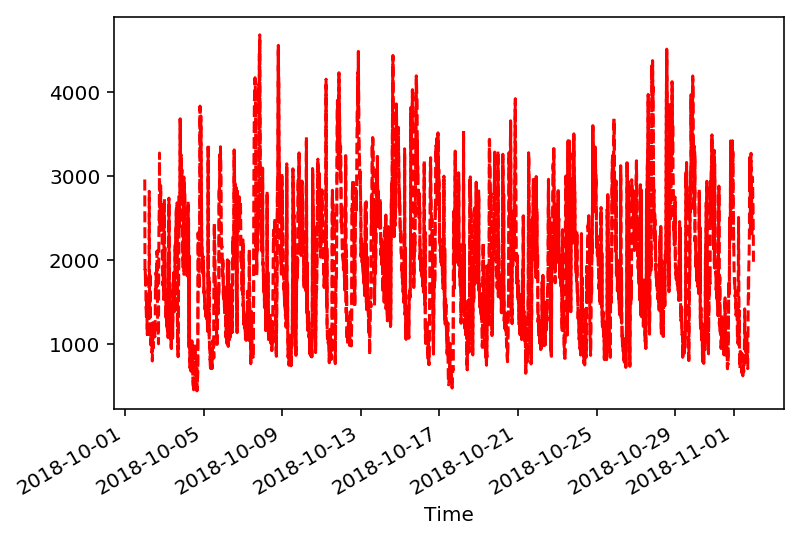

In [96]:
totaldutycycle=0
burden=0
for i in datelist:
    predict_date=i
    rawdata=predict(predict_date)
    realdutycycle=countdutycycle(rawdata,predict_date,burden)[0]
    burden=countdutycycle(rawdata,predict_date,burden)[1]
    totaldutycycle+=realdutycycle

In [102]:
datelist

['2018_11_01',
 '2018_11_02',
 '2018_11_03',
 '2018_11_04',
 '2018_11_05',
 '2018_11_06',
 '2018_11_07',
 '2018_11_08',
 '2018_11_09',
 '2018_11_10',
 '2018_11_11',
 '2018_11_12',
 '2018_11_13',
 '2018_11_14',
 '2018_11_15',
 '2018_11_16',
 '2018_11_17',
 '2018_11_18',
 '2018_11_19',
 '2018_11_20',
 '2018_11_21',
 '2018_11_22',
 '2018_11_23',
 '2018_11_24',
 '2018_11_25',
 '2018_11_26',
 '2018_11_27',
 '2018_11_28',
 '2018_11_29',
 '2018_11_30']

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_mode

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_mode

FileNotFoundError: File b'Energy_Balance_2018_11_00.csv' does not exist

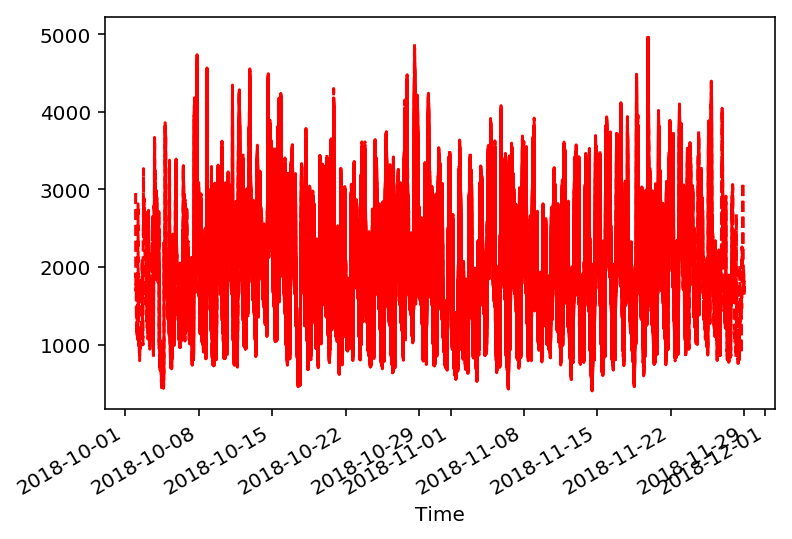

In [99]:
cons11=[]
for i in datelist:
    cons11.append(predictcon(i))


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


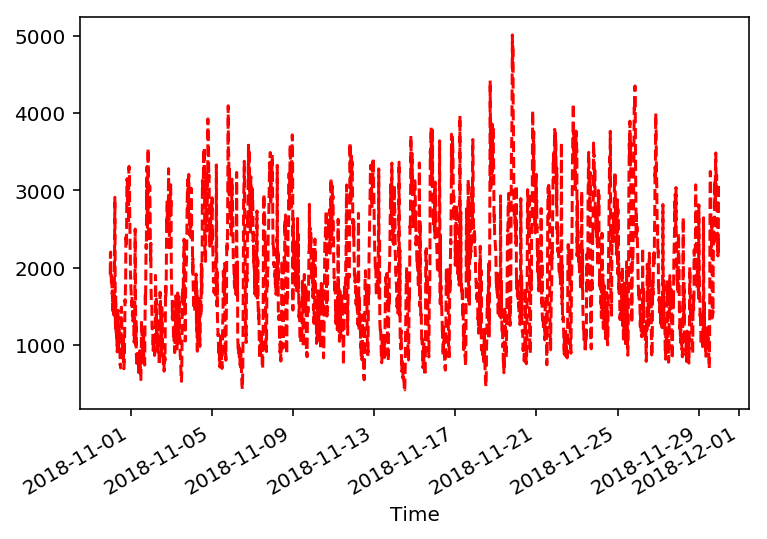

In [110]:
cons11.append(predictcon('2018_11_30'))